## Import Stuff

In [47]:
import tensorflow as tf
import os
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

## Load dataset

In [48]:
path = "dataset/"
sub_paths = ["training/", "testing/", "examples"]

Load images

In [49]:
def load(image_file): # image file is the drawn image
    # Read and decode an image file to a uint8 tensor
    input_image = tf.io.read_file(image_file)
    input_image = tf.io.decode_jpeg(input_image)

    # Convert the image file to a string
    image_file_str = tf.strings.as_string(image_file)  # Convert the symbolic tensor to a string
    
    # Replace "drawn" with "original" in the filename string
    real_image_str = tf.strings.regex_replace(image_file_str, "drawn", "original")
    
    # Convert the string filename back to a symbolic tensor
    real_image = tf.io.read_file(real_image_str)
    real_image = tf.io.decode_jpeg(real_image)

    # Ensure that both images have the same number of channels
    # For example, if one image has 4 channels, convert it to 3 channels
    input_image = input_image[..., :3]  # Keep only the first 3 channels if there are 4
    real_image = real_image[..., :3]  # Keep only the first 3 channels if there are 4
    
    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

Sample of input and output image:

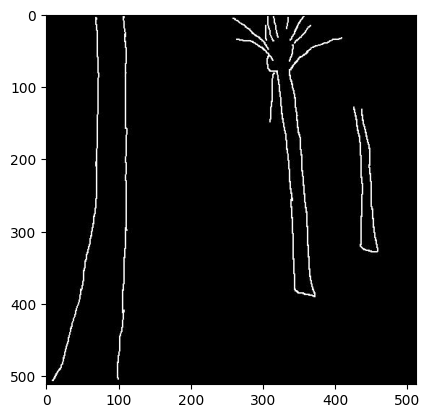

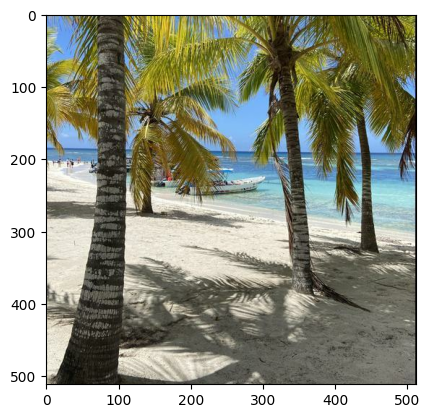

In [50]:
inp, re = load("dataset/train/image_84_drawn.jpg")
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}, you need to apply random jittering and mirroring to preprocess the training set.

Define several functions that:

1. Resize each `256 x 256` image to a larger height and width—`286 x 286`.
2. Randomly crop it back to `256 x 256`.
3. Randomly flip the image horizontally i.e., left to right (random mirroring).
4. Normalize the images to the `[-1, 1]` range.

In [51]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 512x512 in size
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [52]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [53]:
def random_crop(input_image, real_image): 
  stacked_image = tf.stack([input_image, real_image], axis=0)
  
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  print(cropped_image[0], cropped_image[1])
  return cropped_image[0], cropped_image[1]

In [54]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 256) - 1
  real_image = (real_image / 256) - 1

  return input_image, real_image

In [55]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 572, 572)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

Inspect preprocessed output

Tensor("strided_slice:0", shape=(512, 512, 3), dtype=float32) Tensor("strided_slice_1:0", shape=(512, 512, 3), dtype=float32)


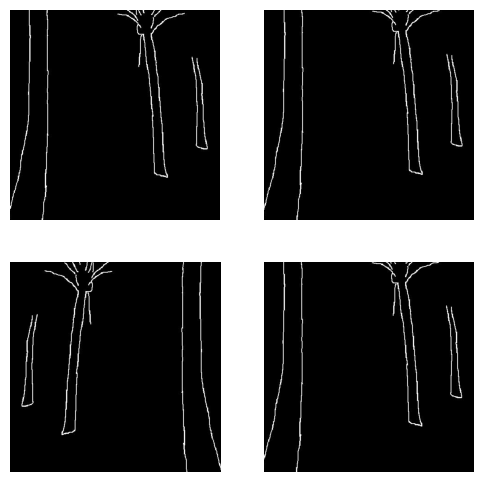

In [56]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [57]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [58]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Build input pipeline with tf.data

In [59]:
# Get a list of JPG files that contain drawings
drawing_files = [os.path.join('dataset/train/', file) for file in os.listdir('dataset/train/') if file.endswith('.jpg') and 'drawn' in file]
print(drawing_files)
# Create a dataset from the filtered list of files
train_dataset = tf.data.Dataset.from_tensor_slices(drawing_files)

train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

['dataset/train/image_102_drawn.jpg', 'dataset/train/image_105_drawn.jpg', 'dataset/train/image_106_drawn.jpg', 'dataset/train/image_107_drawn.jpg', 'dataset/train/image_113_drawn.jpg', 'dataset/train/image_115_drawn.jpg', 'dataset/train/image_122_drawn.jpg', 'dataset/train/image_131_drawn.jpg', 'dataset/train/image_132_drawn.jpg', 'dataset/train/image_149_drawn.jpg', 'dataset/train/image_152_drawn.jpg', 'dataset/train/image_155_drawn.jpg', 'dataset/train/image_157_drawn.jpg', 'dataset/train/image_158_drawn.jpg', 'dataset/train/image_159_drawn.jpg', 'dataset/train/image_16_drawn.jpg', 'dataset/train/image_174_drawn.jpg', 'dataset/train/image_200_drawn.jpg', 'dataset/train/image_211_drawn.jpg', 'dataset/train/image_214_drawn.jpg', 'dataset/train/image_215_drawn.jpg', 'dataset/train/image_217_drawn.jpg', 'dataset/train/image_223_drawn.jpg', 'dataset/train/image_230_drawn.jpg', 'dataset/train/image_238_drawn.jpg', 'dataset/train/image_27_drawn.jpg', 'dataset/train/image_29_drawn.jpg', 'da

In [60]:
# try:
  # test_dataset = tf.data.Dataset.list_files('dataset/test/*.jpg')
# except tf.errors.InvalidArgumentError:
#   test_dataset = tf.data.Dataset.list_files('dataset/val/*.jpg')
# Get a list of JPG files that contain drawings

drawing_files = [os.path.join('dataset/train/', file) for file in os.listdir('dataset/train/') if file.endswith('.jpg') and 'drawn' in file]
print(drawing_files)
# Create a dataset from the filtered list of files
test_dataset = tf.data.Dataset.from_tensor_slices(drawing_files)

test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

['dataset/train/image_102_drawn.jpg', 'dataset/train/image_105_drawn.jpg', 'dataset/train/image_106_drawn.jpg', 'dataset/train/image_107_drawn.jpg', 'dataset/train/image_113_drawn.jpg', 'dataset/train/image_115_drawn.jpg', 'dataset/train/image_122_drawn.jpg', 'dataset/train/image_131_drawn.jpg', 'dataset/train/image_132_drawn.jpg', 'dataset/train/image_149_drawn.jpg', 'dataset/train/image_152_drawn.jpg', 'dataset/train/image_155_drawn.jpg', 'dataset/train/image_157_drawn.jpg', 'dataset/train/image_158_drawn.jpg', 'dataset/train/image_159_drawn.jpg', 'dataset/train/image_16_drawn.jpg', 'dataset/train/image_174_drawn.jpg', 'dataset/train/image_200_drawn.jpg', 'dataset/train/image_211_drawn.jpg', 'dataset/train/image_214_drawn.jpg', 'dataset/train/image_215_drawn.jpg', 'dataset/train/image_217_drawn.jpg', 'dataset/train/image_223_drawn.jpg', 'dataset/train/image_230_drawn.jpg', 'dataset/train/image_238_drawn.jpg', 'dataset/train/image_27_drawn.jpg', 'dataset/train/image_29_drawn.jpg', 'da

## Build the generator

In [61]:
OUTPUT_CHANNELS = 3

Downsampler

In [62]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [63]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 256, 256, 3)


Upsampler

In [64]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [65]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 512, 512, 3)


## Generator:
Eventually false in modifying th upstacking part.

In [66]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[512, 512, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),    # (batch_size, 256, 256, 64)
    downsample(128, 4),                           # (batch_size, 128, 128, 128)
    downsample(256, 4),                           # (batch_size, 64, 64, 256)
    downsample(512, 4),                           # (batch_size, 32, 32, 512)
    downsample(512, 4),                           # (batch_size, 16, 16, 512)
    downsample(512, 4),                           # (batch_size, 8, 8, 512)
    downsample(512, 4),                           # (batch_size, 4, 4, 512)
    downsample(512, 4),                           # (batch_size, 2, 2, 512)
    downsample(512, 4),                           # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),        # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),        # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),        # (batch_size, 8, 8, 1024)
    upsample(512, 4, apply_dropout=True),        # (batch_size, 8, 8, 1024)
    upsample(512, 4),                            # (batch_size, 16, 16, 1024)
    upsample(256, 4),                            # (batch_size, 32, 32, 512)
    upsample(128, 4),                            # (batch_size, 64, 64, 256)
    upsample(64, 4),                             # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Visualize architecture:

In [67]:
generator = Generator()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Test generator

In [123]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

ValueError: Input 0 of layer "model_5" is incompatible with the layer: expected shape=(None, 512, 512, 3), found shape=(1, 1, 512, 512, 3)

Generator loss:

In [69]:
LAMBDA = 100

In [70]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [71]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Discriminator:

In [72]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[512, 512, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[512, 512, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 512, 512, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 256, 256, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 128, 128, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 64, 64, 256)
    down4 = downsample(512, 4)(down3)  # (batch_size, 64, 64, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)  # (batch_size, 66, 66, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (batch_size, 63, 63, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 65, 65, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 62, 62, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


Visualize

In [73]:
discriminator = Discriminator()
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test discriminator

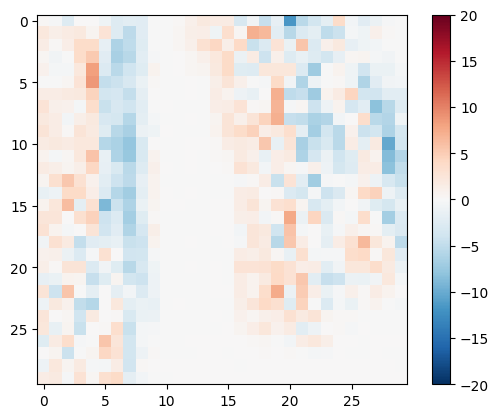

In [74]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

Discriminator loss:

In [75]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Optimizer and checkpoint-saver:

In [76]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [77]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

In [102]:
def generate_images(model, test_input, tar, imgid = 0):
  prediction = model(test_input, training=True) # TODO: Why training=True?
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')

  # Save the plot as an image
  output_path = f"results/result_{imgid}.jpg"
  plt.savefig(output_path)

  plt.show()

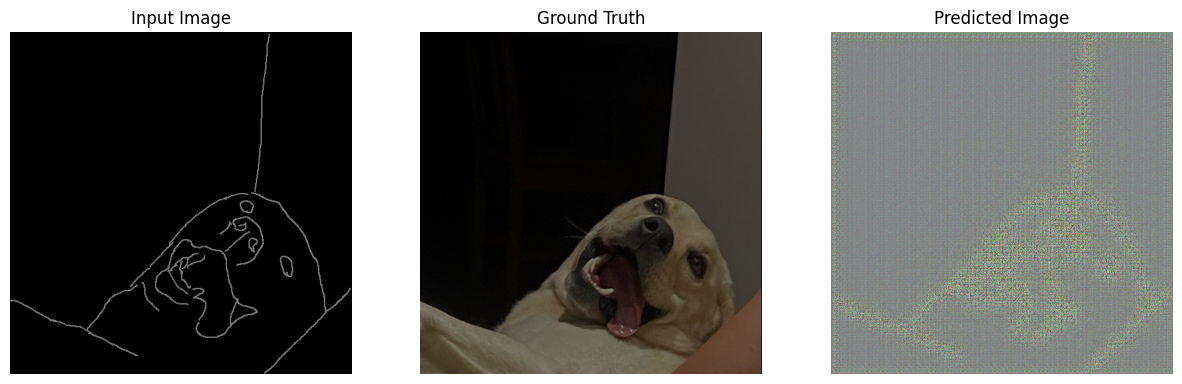

In [79]:
for example_input, example_target in test_dataset.take(1):
  # print(example_input)
  generate_images(generator, example_input, example_target)

## Training

In [80]:
log_dir = "logs"

file_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Construct the full path including the file name
full_path = os.path.join(log_dir, "fit", file_name)

# Create the FileWriter
summary_writer = tf.summary.create_file_writer(full_path)

In [81]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [82]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()
  
  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target, step)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Launch tensorboard viewer:

In [83]:
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

## Run Training:

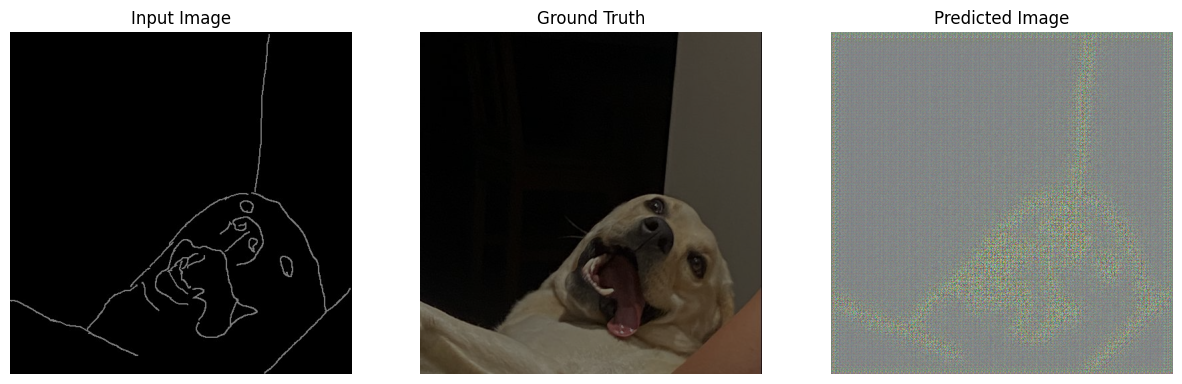

Step: 0k


KeyboardInterrupt: 

In [84]:
fit(train_dataset, test_dataset, steps=40000)

## Restore latest Checkpoint

In [ ]:
files = os.listdir(checkpoint_dir)
print(files)

In [85]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images

(1, 512, 512, 3)


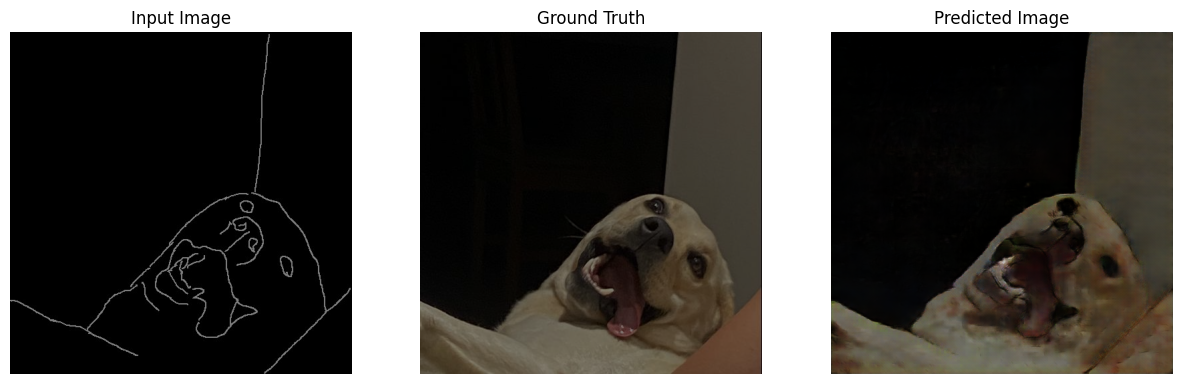

(1, 512, 512, 3)


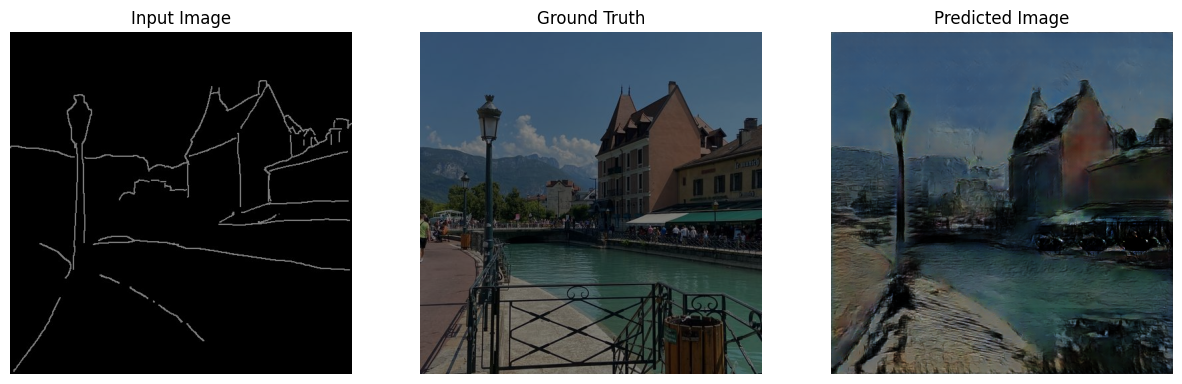

(1, 512, 512, 3)


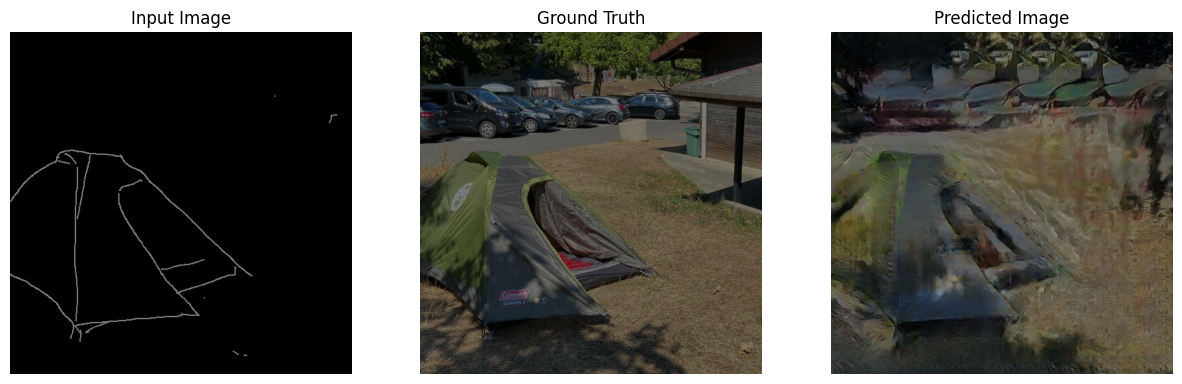

(1, 512, 512, 3)


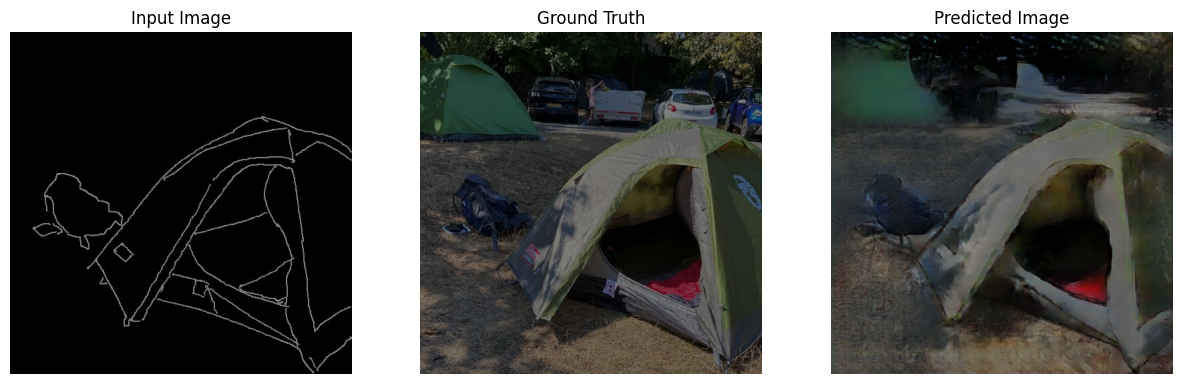

(1, 512, 512, 3)


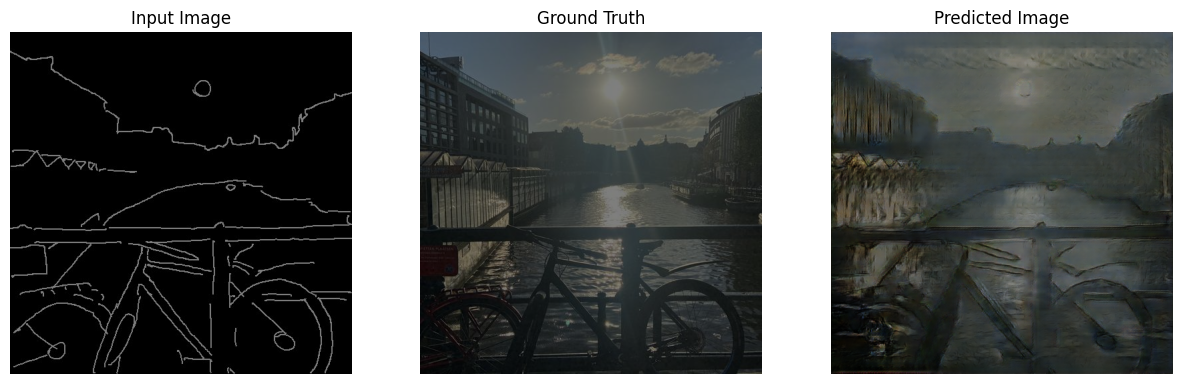

In [105]:
for inp, tar in test_dataset.take(5):
  print(inp.shape)
  generate_images(generator, inp, tar)

### Generate Single Images

In [115]:
def load_and_preprocess_single_image(image_path, img_height=512, img_width=512):
    # Read and decode the image from the file path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Resize the image to the required dimensions
    img = tf.image.resize(img, [img_height, img_width])
    
    # Normalize the image to the [-1, 1] range
    img = (img / 127.5) - 1
    
    # Ensure the image has the correct data type
    img = tf.cast(img, tf.float32)
    
    return img

In [121]:
def generate_single_image(img_path):
    
    # Load and preprocess the image
    input_image = load_and_preprocess_single_image(img_path)

    # Reshape the input image to include batch dimension
    input_image = tf.expand_dims(input_image, axis=0)

    # Use the generator to make a prediction
    prediction = generator(input_image, training=True)

    # Visualize the input image, ground truth, and predicted image
    plt.figure(figsize=(10, 10))
    display_list = [input_image[0], prediction[0]] 
    title = ['Input Image', 'Predicted Image']
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(title[i])
        plt.imshow((display_list[i] * 0.5 + 0.5).numpy())
        plt.axis('off')
    plt.show()

c:\Users\DEBIEMASL\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


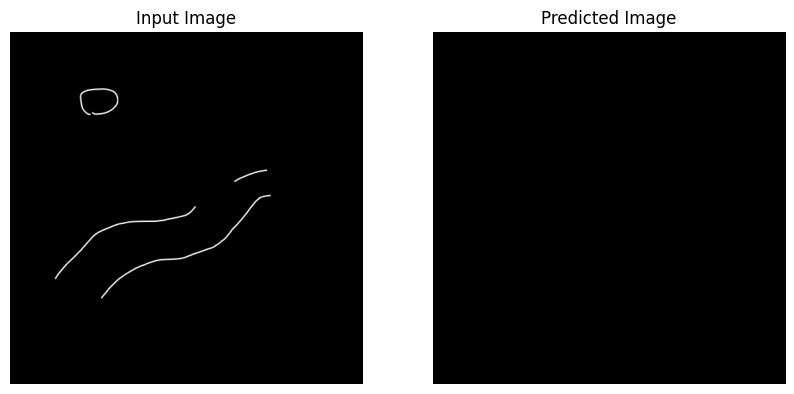

In [122]:
img_path = 'C:\\Users\\DEBIEMASL\\OneDrive - Durr Group\\Dokumente\\Projekte\\Studienarbeit\\test_images\\drawing2.jpeg'
generate_single_image(img_path)